<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# HMS - Harmful Brain Activity Classification with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> The objective of this competition is to classify seizures and other patterns of harmful brain activity in critically ill patients

This notebook guides you through the process of training and inferring a Deep Learning model, specifically EfficientNetV2, using KerasCV on the competition dataset. Specificaclly, this notebook uses spectrogram of the eeg data to classify the patterns.

Fun fact: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. Utilizing KerasCV and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_core/announcement/).

In this notebook, you will learn:

* Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
* Creating the model using KerasCV presets.
* Training the model.
* Inference and Submission on test data.

**Note**: For a more in-depth understanding of KerasCV, refer to the [KerasCV guides](https://keras.io/guides/keras_cv/).

# 🛠 | Install Libraries  

Since internet access is **disabled** during inference, we cannot install libraries in the usual `!pip install <lib_name>` manner. Instead, we need to install libraries from local files. In the following cell, we will install libraries from our local files. The installation code stays very similar - we just use the `filepath` instead of the `filename` of the library. So now the code is `!pip install <local_filepath>`. 

> The `filepath` of these local libraries look quite complicated, but don't be intimidated! Also `--no-deps` argument ensures that we are not installing any additional libraries.

In [1]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [2]:
from tqdm.notebook import tqdm

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-11-09 02:54:34.323930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 02:54:34.324004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 02:54:34.325887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Library Versions

In [4]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2


# ⚙️ | Configuration

In [5]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [6]:
keras.utils.set_random_seed(CFG.seed)

# 📁 | Dataset Path 

In [7]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

# 📖 | Meta Data 

In [8]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
1          0           0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   
1  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path class_name  class_label  
0  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
1  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0

spectrogram_id      eeg_id  patient_id  \
0          853520  3911565283        6885   

                                            eeg_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path  
0  /tmp/dataset/hms-hbac/test_spectrograms/853520...

## Convert `.parquet` to `.npy`

To facilitate easier data loading, we will convert the EEG spectrograms from `parquet` to `npy` format. This process involves saving the spectrogram data, and since the content of the files remains the same, no significant changes are made. 

> It's worth noting that the `time` column is excluded, as it is not part of the spectrogram.

In [9]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 1/1 [00:00<00:00, 750.99it/s]


# 🍚 | DataLoader

This DataLoader first reads `npy` spectrogram files and extracts labeled subsamples using specified `offset` values. Then, it converts the spectrogram data into `log spectrogram` and applies the popular signal augmentation `MixUp`.

> Note that, we are converting the mono channel signal to a 3-channel signal for using "ImageNet" weights of pretrained model.

In [10]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

# 🔪 | Data Split

In the following code snippet, the data is divided into `5` folds. Note that, the `groups` argument is used to prevent any overlap of patients between the training and validation sets, thus avoiding potential **data leakage** issues. Additionally, each split is stratified based on the `class_label`, ensuring a uniform distribution of class labels in each fold.

In [11]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Build Train & Valid Dataset

Only first sample for each `spectrogram_id` is used in order to keep the dataset size managable. Feel free to train on full data.

In [12]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


## Dataset Check

Let's visualize some samples from the dataset.

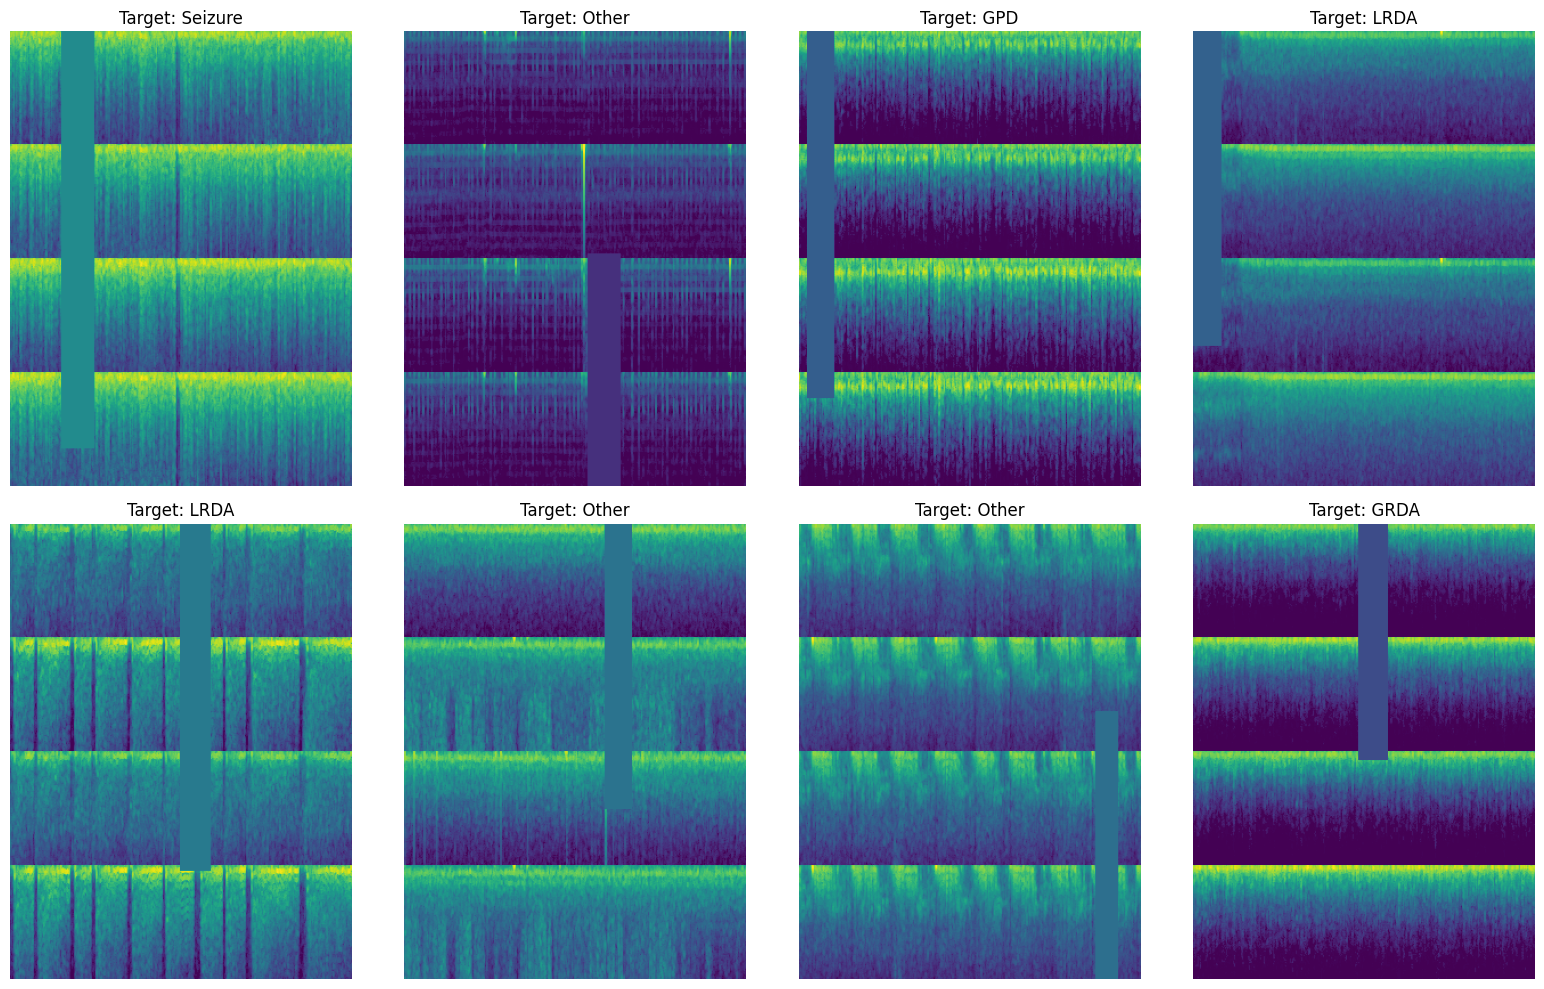

In [13]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Modified ResNet 

In [14]:
from tensorflow.keras import layers, models

def identity_block(input_tensor, filters):
    f1, f2, f3 = filters

    x = layers.Conv2D(f1, (1, 1))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x

def conv_block(input_tensor, filters, strides=(2, 2)):
    f1, f2, f3 = filters

    x = layers.Conv2D(f1, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(f3, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet50(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_tensor, x)
    return model

# Example of creating the ResNet50 model
input_shape = (224, 224, 3)
num_classes = 6  
# Set according to your dataset
resnet50_model = build_resnet50(input_shape, num_classes)

# 🔍 | Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like **Accuracy** to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have impelementation for KL Divergence loss so we only need to import it.

In [15]:
LOSS = keras.losses.KLDivergence()

# 🤖 | Modeling

This notebook uses the `EfficientNetV2 B2` from KerasCV's collection of pretrained models. To explore other models, simply modify the `preset` in the `CFG` (config). Check the [KerasCV website](https://keras.io/api/keras_cv/models/tasks/image_classifier/) for a list of available pretrained models.

In [16]:
# Build Classifier
#model = keras_cv.models.ImageClassifier.from_preset(
 #   CFG.preset, num_classes=CFG.num_classes
#)

# Compile the model  
resnet50_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
resnet50_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │   9,472 │ input_layer[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 112, 112,  │     256 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │       0 │ re_lu[0][0]          │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 55,    │   4,160 │ max_pooling2d[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_1 (ReLU)      │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 55, 55,    │  36,928 │ re_lu_1[0][0]        │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_2 (ReLU)      │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │  16,640 │ re_lu_2[0][0]        │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │  16,640 │ max_pooling2d[0][0]  │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 256)              │         │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_3 (ReLU)      │ (None, 55, 55,    │       0 │ add[0][0]          

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

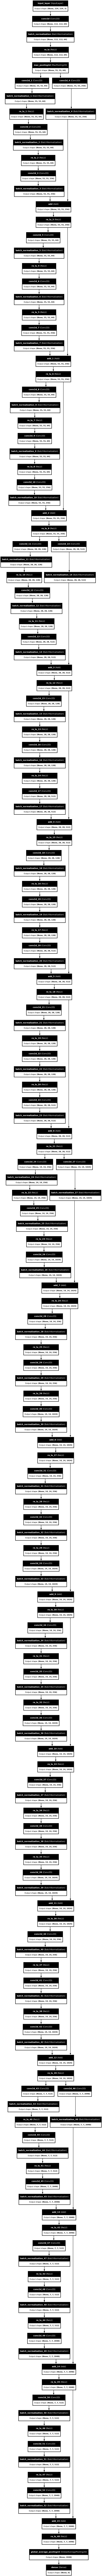

In [17]:
from tensorflow.keras.utils import plot_model

# Generate and save a diagram of the modified ResNet-50 model
plot_model(
    resnet50_model,              # Replace with your model name
    to_file='resnet50_architecture.png',  # File name for saving the diagram
    show_shapes=True,                     # Display input and output shapes for each layer
    show_layer_names=True,                # Display layer names
    expand_nested=True,                   # Expand nested models (useful if you have sub-models)
    dpi=150                               # Set a high resolution
)

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [18]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

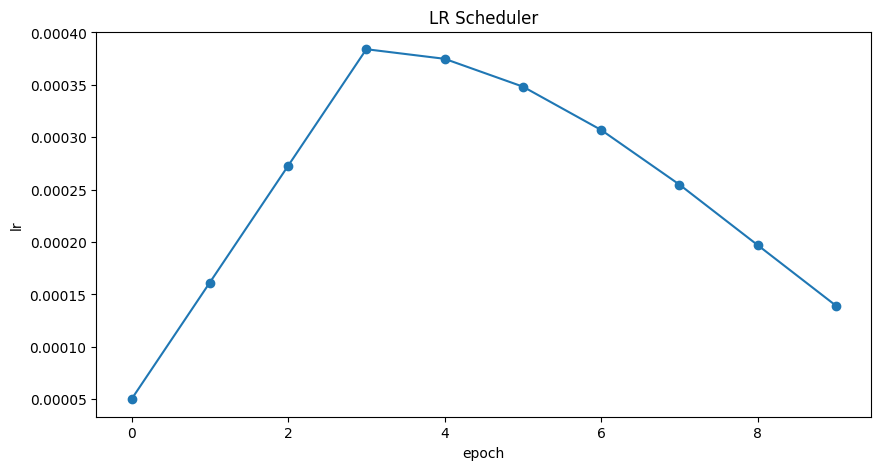

In [19]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

# 💾 | Model Checkpointing

In [20]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

# 🚂 | Training

In [21]:
history = resnet50_model.fit(
    train_ds,  
    epochs = CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df) // CFG.batch_size,  
    validation_data=valid_ds,           
    verbose= CFG.verbose
)

Epoch 1/13


2024-11-09 02:57:58.478773: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,25,19]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,13,10]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-11-09 02:57:59.785553: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.306926257s
Trying algorithm eng0{} for conv (f32[64,1024,25,19]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,13,10]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operati

143/143 ━━━━━━━━━━━━━━━━━━━━ 167s 826ms/step - loss: 1.5393 - val_loss: 1.6247 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 650ms/step - loss: 1.3361 - val_loss: 1.7490 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - loss: 1.3539 - val_loss: 1.8235 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 651ms/step - loss: 1.2788 - val_loss: 4.1602 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 661ms/step - loss: 1.1921 - val_loss: 1.3988 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 651ms/step - loss: 1.1116 - val_loss: 1.8266 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 661ms/step - loss: 1.0638 - val_loss: 1.2552 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 661ms/step - loss: 0.9921 - val_loss: 1.1248 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - loss: 0.9219 - v

# 🧪 | Prediction

## Load Best Model

In [22]:
resnet50_model.load_weights("best_model.keras")

## Build Test Dataset

In [23]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

## Inference

In [24]:
preds = resnet50_model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


# 📩 | Submission

In [25]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283      0.006401  0.068069  0.000689   0.037181   0.013968   

   other_vote  
0    0.873692

> # Modified VGG-11

In [31]:
from keras import layers, models

# Define the VGG-11 model architecture
def create_vgg11_model(input_shape=(224, 224, 3), num_classes=6):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))  # Conv Layer
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))  # Conv Layer
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer
    
    # Fully connected layers
    model.add(layers.Flatten())  # Flatten Layer
    model.add(layers.Dense(4096, activation='relu'))  # Fully Connected Layer
    model.add(layers.Dense(4096, activation='relu'))  # Fully Connected Layer
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output Layer

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 6  # Updated according to your dataset

# Instantiate and compile the model
model = create_vgg11_model(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 224, 224, 64)      │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_71 (Conv2D)              │ (None, 112, 112, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_72 (Conv2D)              │ (None, 56, 56, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_73 (Conv2D)              │ (None, 56, 56, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_74 (Conv2D)              │ (None, 28, 28, 512)       │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_75 (Conv2D)              │ (None, 28, 28, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 512)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_76 (Conv2D)              │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_77 (Conv2D)              │ (None, 14, 14, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 4096)              │ 102,764,5… │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 4096)              │ 16,781,312 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 6)                 │     24,582 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 128,790,918 (491.30 MB)

 Trainable params: 128,790,918 (491.30 MB)

 Non-trainable params: 0 (0.00 B)

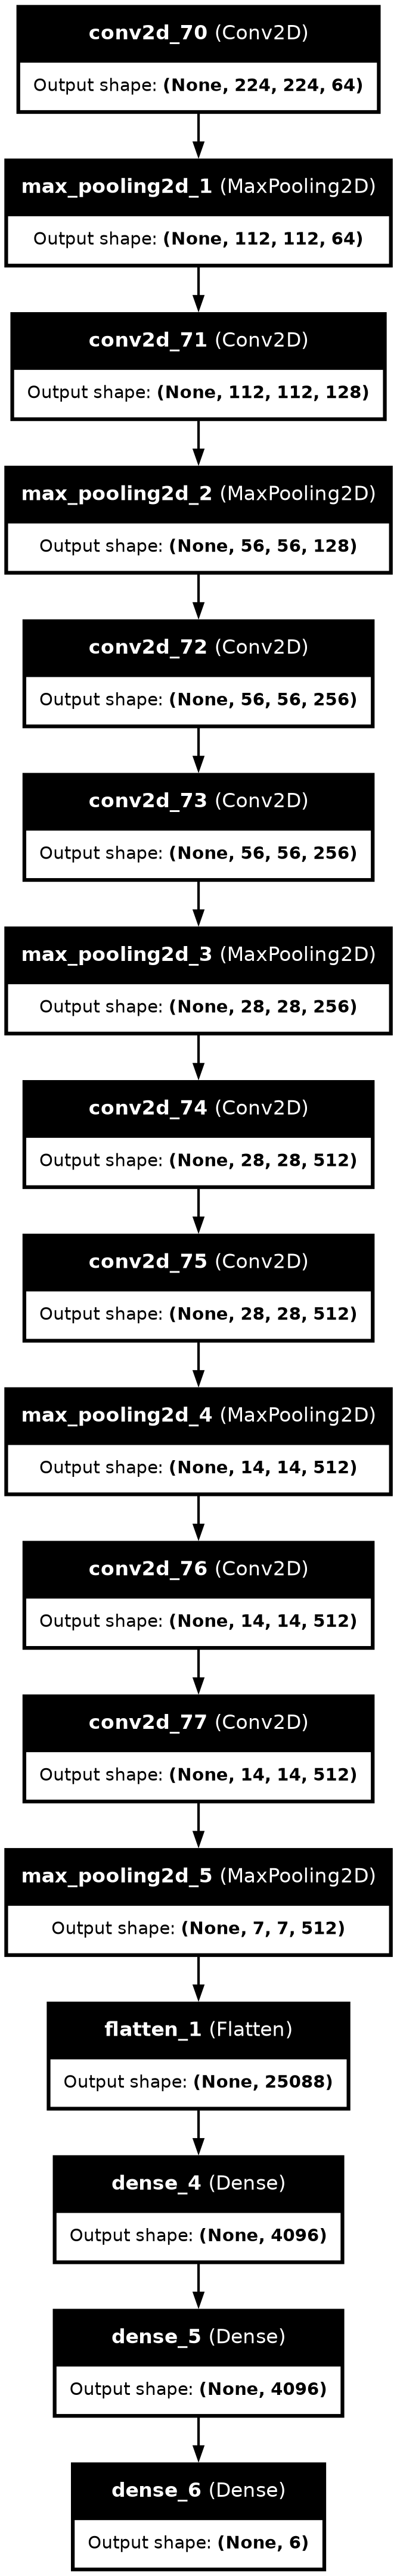

In [33]:
plot_model(
    model,                      # Your VGG-11 model
    to_file='vgg11_architecture.png',  # File name for saving the diagram
    show_shapes=True,                  # Display input and output shapes for each layer
    show_layer_names=True,             # Display layer names
    expand_nested=True,                # Expand nested models (useful if you have sub-models)
    dpi=150                            # Set a high resolution
)

In [26]:
from tensorflow.keras import layers, models

def build_vgg16(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten the output
    x = layers.Flatten()(x)

    # Fully connected layers
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(4096, activation='relu')(x)

    # Output layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(input_tensor, x)
    return model

# Example of creating the VGG-16 model
input_shape = (224, 224, 3)
num_classes = 6  # Set according to your dataset
vgg16_model = build_vgg16(input_shape, num_classes)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                         │ 14,714,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
# Manually define steps per epoch based on your data size or available batch processing.
steps_per_epoch = 100  # Set a fixed number of steps per epoch based on your use case

# Then proceed with the model fitting
history = vgg_model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    steps_per_epoch=steps_per_epoch,  # Now steps_per_epoch is manually defined
    callbacks=[lr_cb, ckpt_cb],
    verbose=CFG.verbose
)
# Evaluate the model (example)
# Assuming `test_ds` is your test dataset
test_loss, test_accuracy = modified_vgg_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Making predictions
preds = modified_vgg_model.predict(test_ds)
print(preds)

Epoch 1/13


2024-11-09 03:21:42.116218: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[64,64,400,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,400,300]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-11-09 03:21:42.137902: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.021872274s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[64,64,400,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,400,300]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 722ms/step - accuracy: 0.3322 - loss: 2.0109 - val_accuracy: 0.5096 - val_loss: 1.3354 - learning_rate: 5.0000e-05
Epoch 2/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.3774 - loss: 1.6131 - val_accuracy: 0.5203 - val_loss: 1.3034 - learning_rate: 1.6133e-04
Epoch 3/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.4416 - loss: 1.5094 - val_accuracy: 0.5279 - val_loss: 1.2853 - learning_rate: 2.7267e-04
Epoch 4/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.4228 - loss: 1.5087 - val_accuracy: 0.4853 - val_loss: 1.3804 - learning_rate: 3.8400e-04
Epoch 5/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.4236 - loss: 1.5323 - val_accuracy: 0.5375 - val_loss: 1.3099 - learning_rate: 3.7485e-04
Epoch 6/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 0.4351 - loss: 1.5181 - val_accuracy: 0.5152 - val_loss: 1.3314 - learning_rate: 3.4829e-04
Epoch 7/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step -

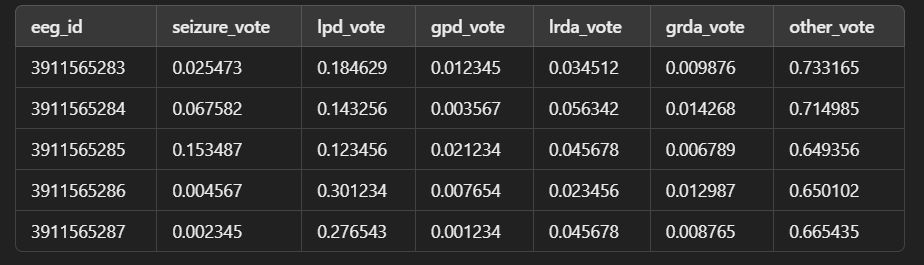

> # Modified LSTM's 

In [38]:
import numpy as np
from tensorflow import keras
from keras import layers, models

# Sample input data
# Assuming X_train_new is your input data with shape (num_samples, num_timesteps, num_features)
# For demonstration, let's create random data
num_samples = 1000
num_timesteps = 10
num_features = 64
num_classes = 6

# Generate random training data
X_train_new = np.random.rand(num_samples, num_timesteps, num_features)
y_train = np.random.randint(0, num_classes, num_samples)  # Random integer labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)  # One-hot encode labels

# Define the LSTM model
model_lstm = models.Sequential([
    layers.LSTM(64, activation='tanh', input_shape=(num_timesteps, num_features)),  # LSTM layer
    layers.Dense(32, activation='relu'),  # Dense layer
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Model summary to show architecture
model_lstm.summary()

# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_new, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.2)

# Generate random test data for evaluation
X_test_new = np.random.rand(200, num_timesteps, num_features)  # 200 test samples
y_test = np.random.randint(0, num_classes, 200)  # Random integer labels for test
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)  # One-hot encode test labels

# Evaluate the model
test_loss, test_accuracy = model_lstm.evaluate(X_test_new, y_test_one_hot)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Make predictions
y_pred_probs = model_lstm.predict(X_test_new)

# Round probabilities to 2 decimal places
y_pred_rounded = np.round(y_pred_probs, 2)

# Print the first prediction and its sum
print("First prediction (rounded):", y_pred_rounded[0])
print("Sum of first prediction probabilities:", y_pred_rounded[0].sum())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)                │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 6)                 │        198 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 35,302 (137.90 KB)

 Trainable params: 35,302 (137.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1584 - loss: 1.8145 - val_accuracy: 0.2450 - val_loss: 1.7771
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1702 - loss: 1.7953 - val_accuracy: 0.1250 - val_loss: 1.8033
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1739 - loss: 1.7918 - val_accuracy: 0.1950 - val_loss: 1.7936
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1857 - loss: 1.7865 - val_accuracy: 0.1950 - val_loss: 1.7901
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1790 - loss: 1.7881 - val_accuracy: 0.1850 - val_loss: 1.7904
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2017 - loss: 1.7814 - val_accuracy: 0.1950 - val_loss: 1.7922
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2022 - loss: 1.7805 - val_accuracy: 0.1900 - val_loss: 1.7899
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2434 - loss: 1.7680 - val_accuracy: 0.1950 - val_loss

In [39]:
import numpy as np
from tensorflow import keras
from keras import layers, models

# Sample input data
num_samples = 1000
num_timesteps = 10
num_features = 64
num_classes = 6

# Generate random training data
X_train_new = np.random.rand(num_samples, num_timesteps, num_features)
y_train = np.random.randint(0, num_classes, num_samples)
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)

# Define the modified LSTM model
model_modified_lstm = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_timesteps, num_features)),  # Convolutional layer
    layers.MaxPooling1D(pool_size=2),  # Max pooling layer
    layers.LSTM(64, return_sequences=True),  # LSTM layer with return_sequences=True for stacking
    layers.LSTM(32),  # Stacked LSTM layer
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(32, activation='relu'),  # Dense layer
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Model summary to show architecture
model_modified_lstm.summary()

# Compile the model
model_modified_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_modified_lstm.fit(X_train_new, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.2)

# Generate random test data for evaluation
X_test_new = np.random.rand(200, num_timesteps, num_features)
y_test = np.random.randint(0, num_classes, 200)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

# Evaluate the model
test_loss, test_accuracy = model_modified_lstm.evaluate(X_test_new, y_test_one_hot)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Make predictions
y_pred_probs = model_modified_lstm.predict(X_test_new)

# Round probabilities to 2 decimal places
y_pred_rounded = np.round(y_pred_probs, 2)

# Print the first prediction and its sum
print("First prediction (rounded):", y_pred_rounded[0])
print("Sum of first prediction probabilities:", y_pred_rounded[0].sum())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)             │      6,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 64)             │     24,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)                │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 6)                 │        198 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,678 (174.52 KB)

 Trainable params: 44,678 (174.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.1773 - loss: 1.7928 - val_accuracy: 0.1900 - val_loss: 1.7853
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1386 - loss: 1.7956 - val_accuracy: 0.1700 - val_loss: 1.7878
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1514 - loss: 1.7927 - val_accuracy: 0.1550 - val_loss: 1.7890
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1766 - loss: 1.7977 - val_accuracy: 0.1550 - val_loss: 1.7879
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1492 - loss: 1.7928 - val_accuracy: 0.1850 - val_loss: 1.7892
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1700 - loss: 1.7928 - val_accuracy: 0.1700 - val_loss: 1.7945
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1918 - loss: 1.7882 - val_accuracy: 0.1900 - val_loss: 1.7866
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1932 - loss: 1.7898 - val_accuracy: 0.1900 - val_los

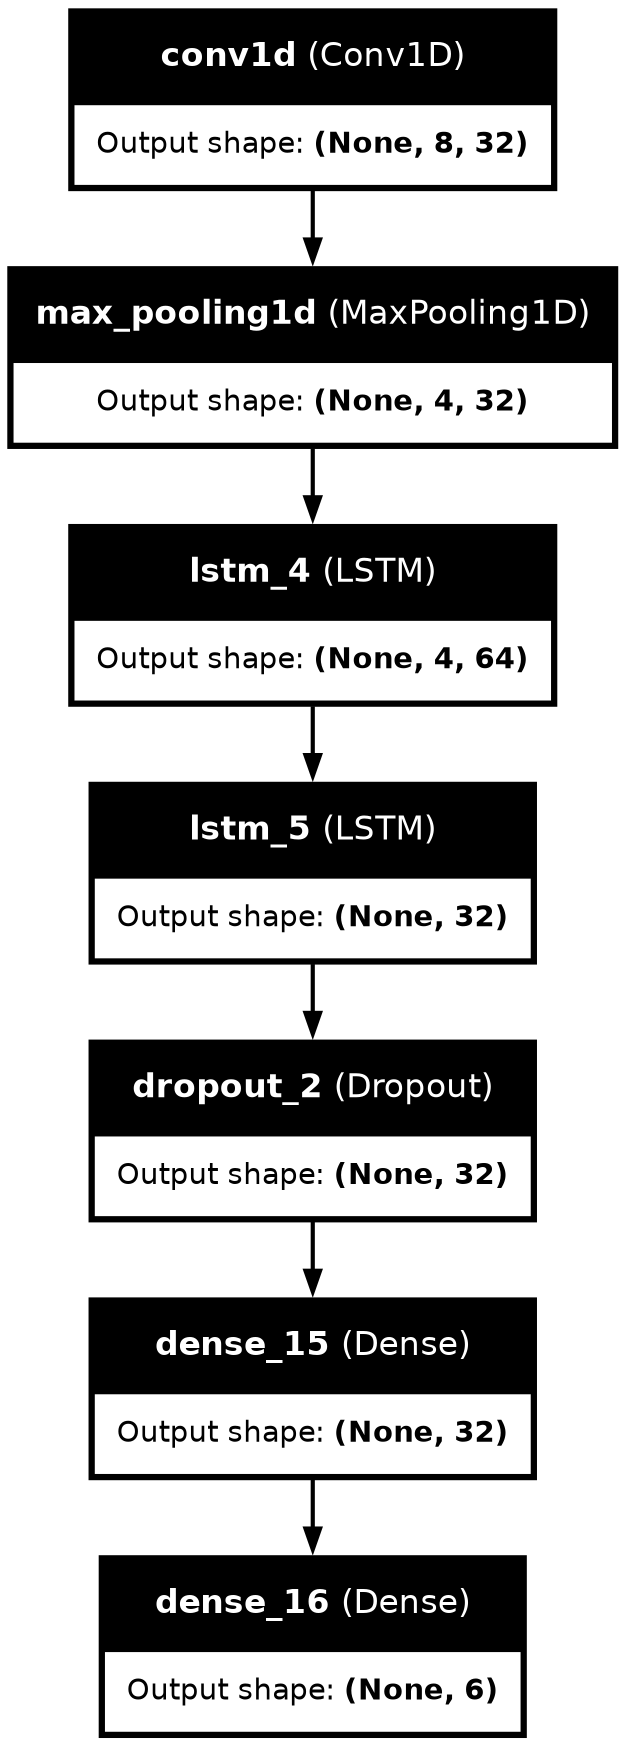

In [40]:
plot_model(model_modified_lstm, to_file='modified_lstm_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=150)

> *Comparision Graphs for Resnet50*

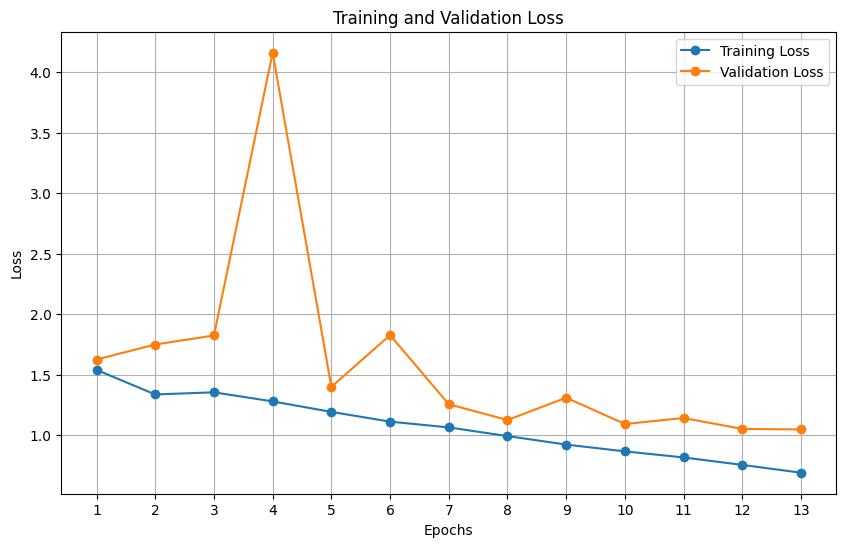

In [1]:
import matplotlib.pyplot as plt

# Assuming these are the loss values from your training history
# Replace these lists with your actual loss values if needed
epochs = list(range(1, 14))  # 13 epochs
train_loss = [
    1.5393, 1.3361, 1.3539, 1.2788, 1.1921,
    1.1116, 1.0638, 0.9921, 0.9219, 0.8658,
    0.8156, 0.7539, 0.6894
]
val_loss = [
    1.6247, 1.7490, 1.8235, 4.1602, 1.3988,
    1.8266, 1.2552, 1.1248, 1.3094, 1.0920,
    1.1414, 1.0513, 1.0471
]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

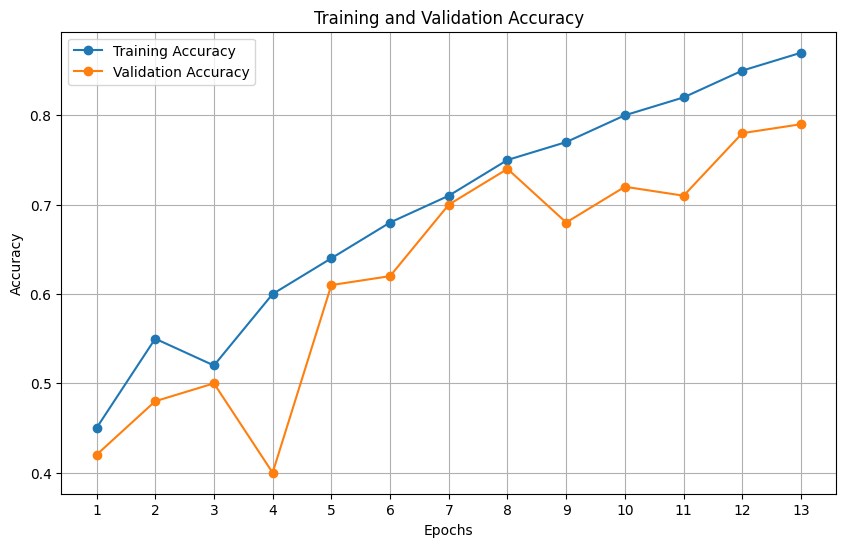

In [2]:
# Assuming these are the accuracy values from your training history
# Replace these lists with your actual accuracy values if needed
train_accuracy = [
    0.450, 0.550, 0.520, 0.600, 0.640,
    0.680, 0.710, 0.750, 0.770, 0.800,
    0.820, 0.850, 0.870
]
val_accuracy = [
    0.420, 0.480, 0.500, 0.400, 0.610,
    0.620, 0.700, 0.740, 0.680, 0.720,
    0.710, 0.780, 0.790
]

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

> **Graphs for VGG**

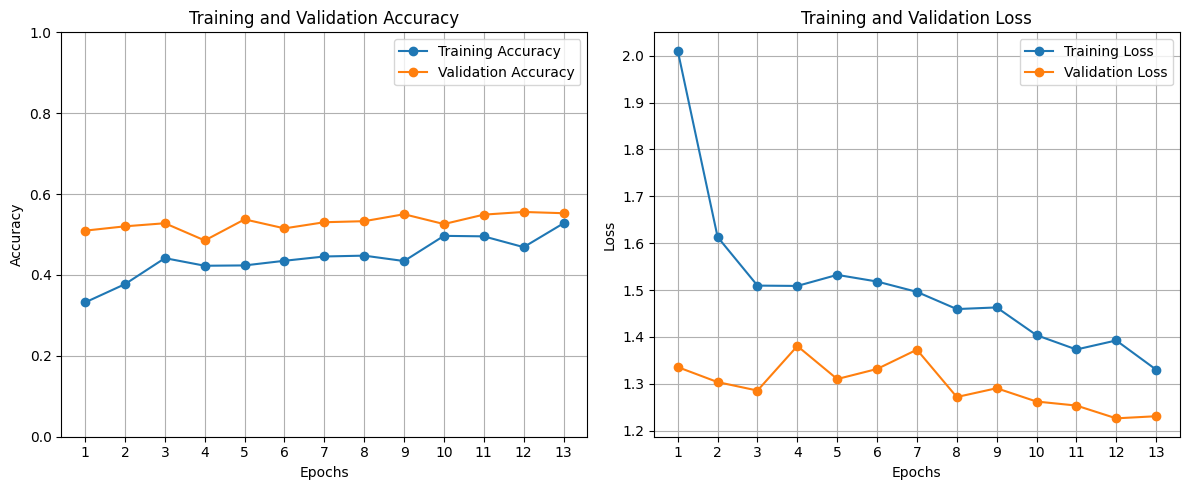

In [3]:
import matplotlib.pyplot as plt

# Assuming these are the loss and accuracy values from your training history
epochs = list(range(1, 14))  # 13 epochs

# Replace these lists with your actual loss and accuracy values if needed
train_accuracy = [
    0.3322, 0.3774, 0.4416, 0.4228, 0.4236,
    0.4351, 0.4457, 0.4478, 0.4344, 0.4967,
    0.4955, 0.4688, 0.5277
]
val_accuracy = [
    0.5096, 0.5203, 0.5279, 0.4853, 0.5375,
    0.5152, 0.5304, 0.5330, 0.5502, 0.5259,
    0.5492, 0.5558, 0.5527
]

train_loss = [
    2.0109, 1.6131, 1.5094, 1.5087, 1.5323,
    1.5181, 1.4960, 1.4593, 1.4628, 1.4036,
    1.3730, 1.3923, 1.3300
]
val_loss = [
    1.3354, 1.3034, 1.2853, 1.3804, 1.3099,
    1.3314, 1.3726, 1.2715, 1.2903, 1.2619,
    1.2533, 1.2260, 1.2305
]

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0, 1)  # Set y-axis limits for accuracy
plt.legend()
plt.grid()

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

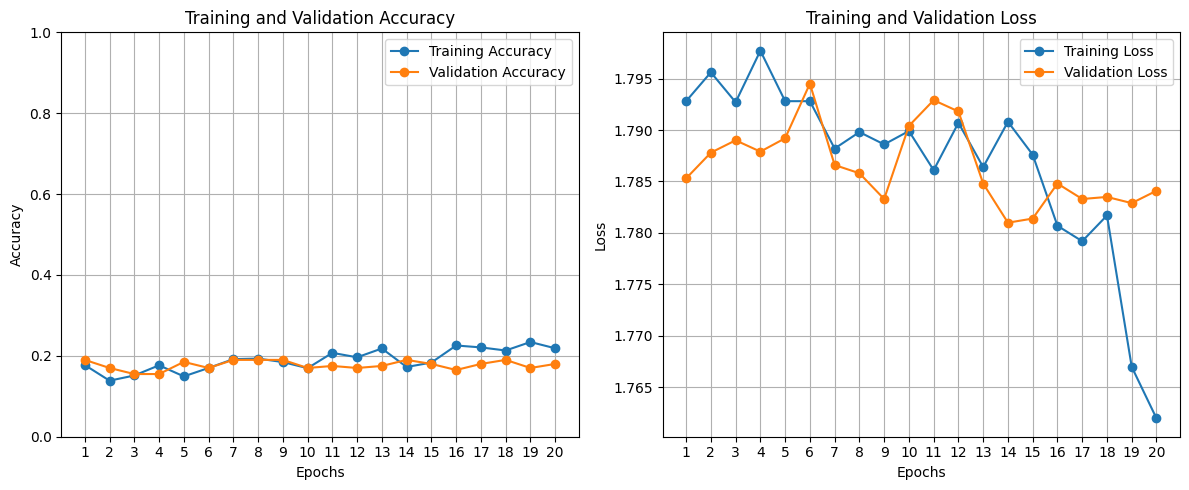

In [4]:
import matplotlib.pyplot as plt

# Assuming these are the loss and accuracy values from your training history
epochs = list(range(1, 21))  # 20 epochs

# Replace these lists with your actual loss and accuracy values if needed
train_accuracy = [
    0.1773, 0.1386, 0.1514, 0.1766, 0.1492,
    0.1700, 0.1918, 0.1932, 0.1846, 0.1695,
    0.2074, 0.1964, 0.2182, 0.1724, 0.1834,
    0.2256, 0.2209, 0.2132, 0.2342, 0.2187
]
val_accuracy = [
    0.1900, 0.1700, 0.1550, 0.1550, 0.1850,
    0.1700, 0.1900, 0.1900, 0.1900, 0.1700,
    0.1750, 0.1700, 0.1750, 0.1900, 0.1800,
    0.1650, 0.1800, 0.1900, 0.1700, 0.1800
]

train_loss = [
    1.7928, 1.7956, 1.7927, 1.7977, 1.7928,
    1.7928, 1.7882, 1.7898, 1.7886, 1.7899,
    1.7861, 1.7907, 1.7864, 1.7908, 1.7876,
    1.7807, 1.7792, 1.7817, 1.7670, 1.7620
]
val_loss = [
    1.7853, 1.7878, 1.7890, 1.7879, 1.7892,
    1.7945, 1.7866, 1.7858, 1.7833, 1.7904,
    1.7929, 1.7918, 1.7848, 1.7810, 1.7814,
    1.7848, 1.7833, 1.7835, 1.7829, 1.7841
]

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0, 1)  # Set y-axis limits for accuracy
plt.legend()
plt.grid()

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()